<a href="https://colab.research.google.com/github/hhaemin/smart_healthcare/blob/main/Image_segmentation_%EB%B0%B0%ED%8F%AC%EC%9A%A9%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


## Image Segmentation

Image Segmentation의 과제는 영상의 픽셀 단위의 마스크를 출력하도록 신경망를 훈련시키는 것입니다. 이미지 분할은 의료 영상, 자율주행차, 위성 영상화 분야에서 많이 응용이 되고 있습니다.

이번 튜토리얼에 사용 될 데이터 세트는  Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)입니다. 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성됩니다. 마스크는 기본적으로 각 픽셀의 레이블입니다. 각 픽셀은 다음 세 가지 범주 중 하나가 주어집니다:

*   class 1 : 애완동물이 속한 픽셀
*   class 2 : 애완동물과 인접한 픽셀
*   class 3 : 위에 속하지 않는 경우/주변 픽셀

In [1]:
# 실습을 위한 clone
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-m0n0ngg9
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-m0n0ngg9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 필요 모듈 import


In [3]:
import tensorflow as tf # local GPU-NVIDIA, CUDA, cuDNN 제공하는 그래픽 카드 -> tensorflow-gpu

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Pets 데이터 세트를 다운로드 하기

데이터 세트는 이미 텐서플로 데이터 세트에 포함되어 있으며, 다운로드만 하면 됩니다.

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) # tensorflow datasets에서 oxford_iiit 데이터 다운

- 이미지를 뒤집는 간단한 augmentation을 수행  
- Image 정규화  
- 분할 마스크의 픽셀에 {1, 2, 3}이라는 레이블 생성  
- 편의성을 위해 segment mask에 1을 빼서 레이블 값을 {0, 1, 2}로 수정

In [6]:
def normalize(input_image, input_mask): # 정규화 작업
  input_image = tf.cast(input_image, tf.float32) / 255.0 # tf.cast(data, type) -> data를 type로 형변환
  input_mask -= 1 # mask label값에서 -1 할당
  return input_image, input_mask

In [8]:
@tf.function # 데코레이터로 tf.function 선언
def load_image_train(datapoint): # 이미지 불러오는 함수 선언, train data
  input_image = tf.image.resize(datapoint['image'], (128, 128)) # input_image resize 
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128)) # segmentation을 할 mask도 같은 사이즈로 resize

  if tf.random.uniform(()) > 0.5: # random한 수치를 뽑아 0.5보다 큰 경우 flip 실행
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
def load_image_test(datapoint): # test data, train과 동일일
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask) # normalize 진행행

  return input_image, input_mask

In [10]:
info # 데이터 정보 확인

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shufflin

In [11]:
info.splits['train'] # Train 데이터만 확인인

<SplitInfo num_examples=3680, num_shards=4>

데이터 세트에 이미 필요한 만큼의 Test와 Training이 포함되어 있으므로 동일한 분할을 계속 사용

In [12]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [13]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE) # map함수를 적용하여 생성해놓은 load_image_train 메소드를 적용용
test = dataset['test'].map(load_image_test)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # shuffling
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

이미지 예제와 데이터 세트에서 대응하는 마스크를 segment mask확인 

In [15]:
def display(display_list): # 출력 메소드 작성
  plt.figure(figsize=(15, 15)) # 크기

  title = ['Input Image', 'True Mask', 'Predicted Mask'] # 타이틀 설정

  for i in range(len(display_list)): # list형 데이터를 받아서 출력
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) # array 값을 img로 변환하여 출력
    plt.axis('off')
  plt.show()

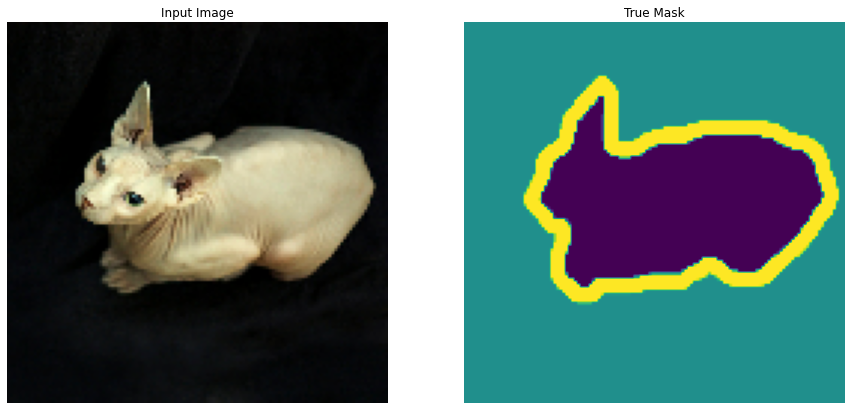

In [16]:
for image, mask in train.take(1): # 1번 데이터만 sample로 출력력
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 모델 정의
- 수정된 U-Net 모델 사용  
- U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함  
- 인코더는 미리 훈련된 MobileNetV2 모델 → 모델의 중간 출력을 사용
- 디코더는 [Pix2pix 튜토리얼](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)의 TensorFlow 예제에서 이미 구현된 업샘플 블록

3개의 채널을 출력하는 이유 → 픽셀당 3개의 표현 가능한 라벨이 있기 때문  
⟹ 각 화소가 세 개의 class로 분류되는 다중 분류

In [17]:
OUTPUT_CHANNELS = 3

- 인코더는 미리 훈련된 MobileNetV2 모델
- 인코더는 모델의 중간 층에서 나오는 feature extraction으로 구성 (인코더는 학습X)

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False) # base 모델 설정

# layer들의 activation function
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers) # 미리 학습된 가중치 download

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


디코더/업샘플러는 TensorFlow 예제에서 구현된 일련의 업샘플 블록

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels): # U-net model 생성
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # skip-connection 설정 
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate() # skip-connection을 upsampling과 연결
    x = concat([x, skip])

  # 모델의 마지막 층
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 모델 훈련
- 손실 함수 : loss.sparse_categorical_crossentropy
- create_mask 함수 : 네트워크의 출력을 사용하여 픽셀에 할당된 레이블중 가장 높은 값을 가진 채널을 취득하는 함수

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', # adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # sparse_categorical_crossentropy : 다중분류 손실함수. integer type class. one-hot encoding 과정X
              metrics=['accuracy'])

만들어진 모델의 구조

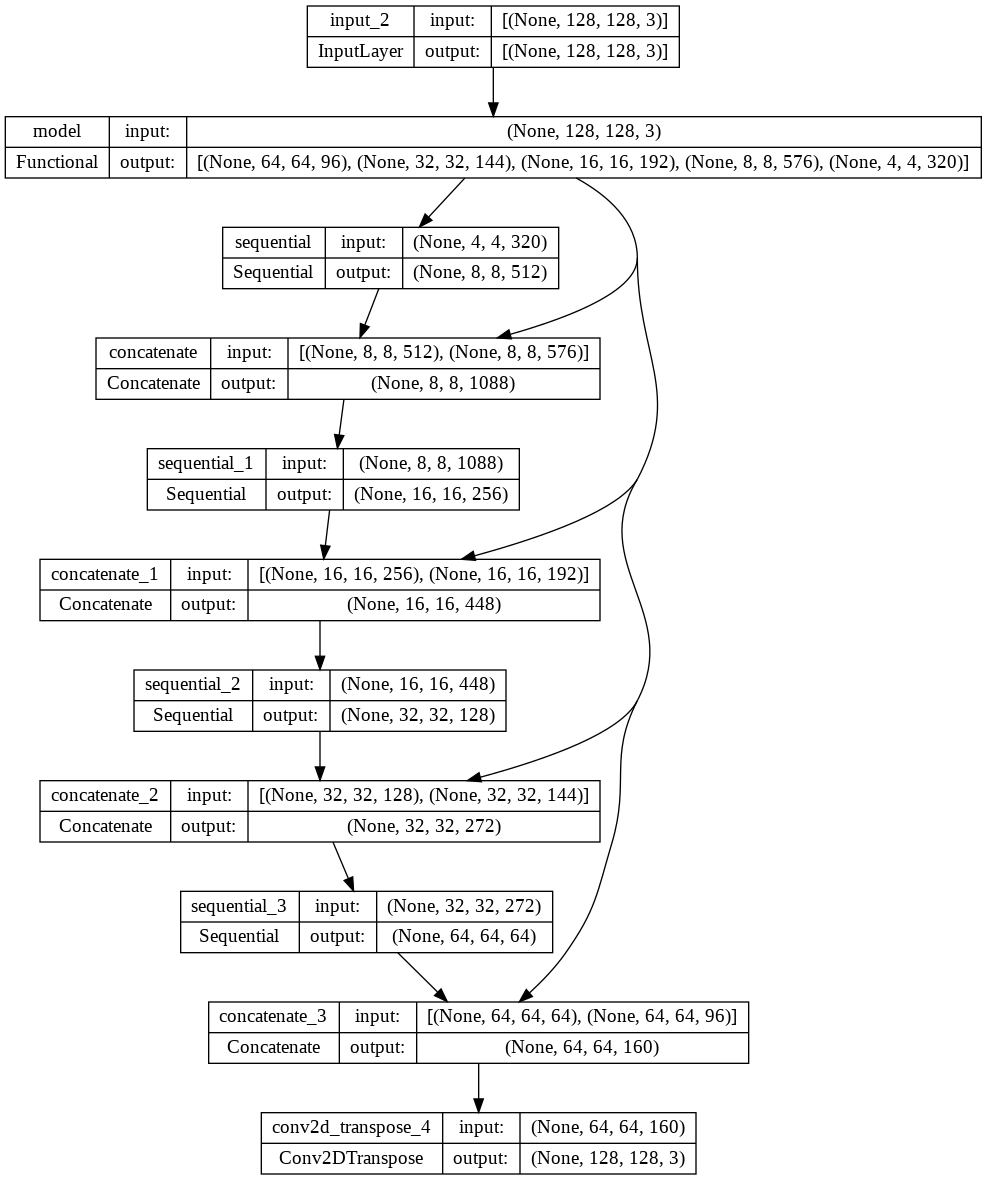

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

모델을 시험해보고 훈련 전에 예측한 것 확인

In [23]:
def create_mask(pred_mask): # 예측 마스크 생성성
  pred_mask = tf.argmax(pred_mask, axis=-1) # argmax값을 추출
  pred_mask = pred_mask[..., tf.newaxis] # 새로운 축 생성성
  return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1): # 예측값 출력력
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 11s 11s/step


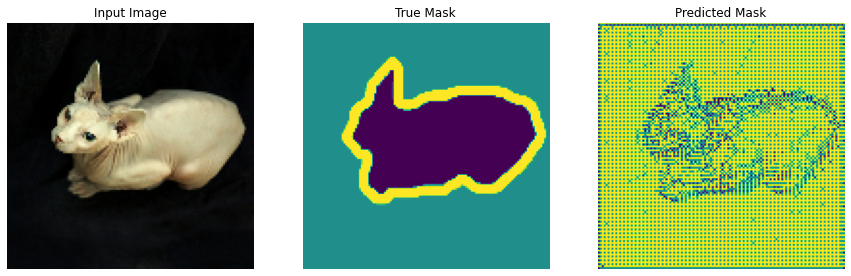

In [25]:
show_predictions()

훈련 과정 확인 및 Callback 함수 정의 

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback): # Callback : 모델을 학습증 호출할 수 있는 기능
  def on_epoch_end(self, epoch, logs=None): # epoch이 끝날 때
    clear_output(wait=True)
    show_predictions()
    print ('epoch(훈련) 이후 예측 예시 {}\n'.format(epoch+1))

1/1 [==============================] - 0s 23ms/step


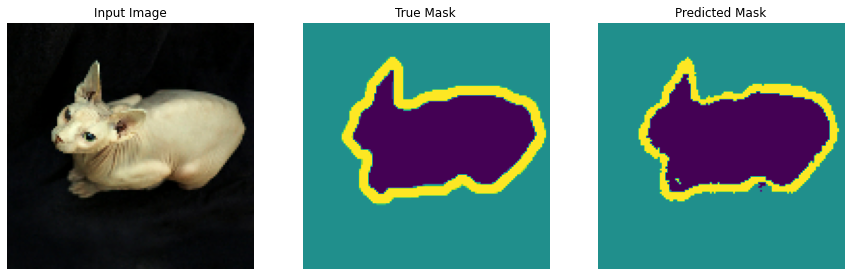

epoch(훈련) 이후 예측 예시 5

57/57 [==============================] - 9s 155ms/step - loss: 0.2493 - accuracy: 0.8948 - val_loss: 0.2788 - val_accuracy: 0.8870


In [27]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

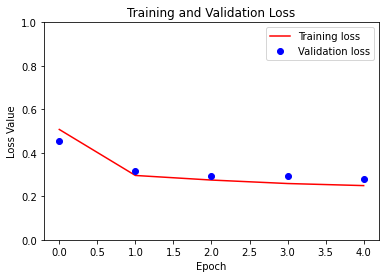

In [28]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS) 

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 예측

2/2 [==============================] - 0s 57ms/step


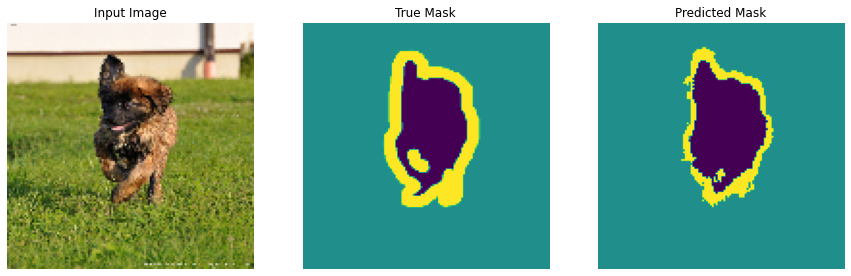

2/2 [==============================] - 0s 63ms/step


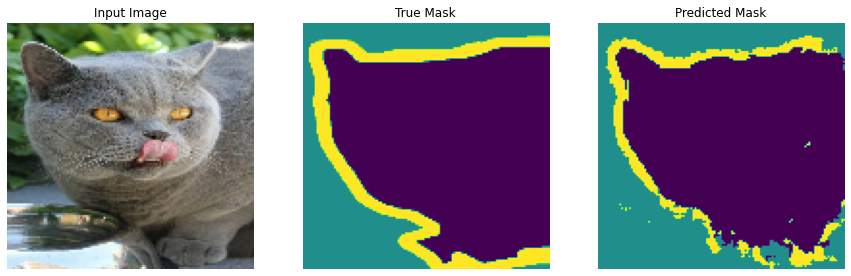

2/2 [==============================] - 0s 45ms/step


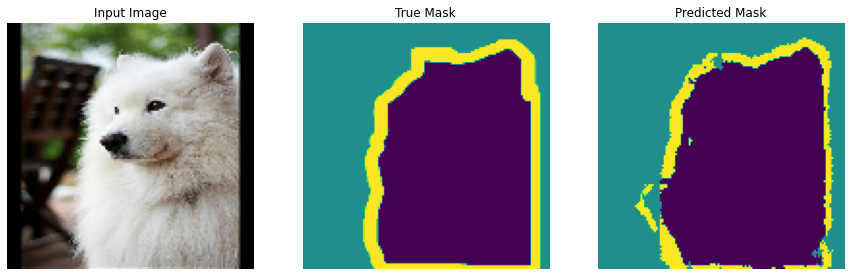

2/2 [==============================] - 0s 44ms/step


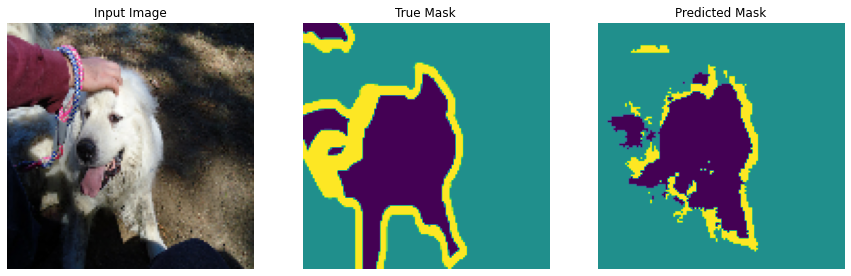

2/2 [==============================] - 0s 53ms/step


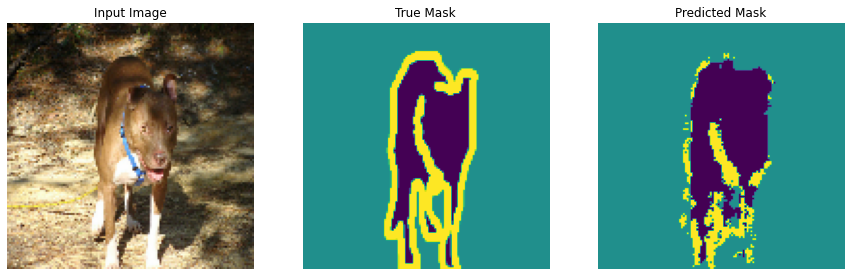

In [29]:
show_predictions(test_dataset, 5)